In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchvision.transforms import *
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import copy
%matplotlib inline

In [23]:
EPOCHS = 200
EPOCH_PATIENCE = 10
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_CLASSES = 102
WEIGHT_DECAY = 1e-4

In [24]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.fc1 = nn.Linear(256 * 14 * 14, 1024)
        self.fc2 = nn.Linear(1024, NUM_CLASSES)
        
        self.dropout = nn.Dropout(0.5)

    def forward(self, X):
        X = F.relu(self.bn1(F.max_pool2d(self.conv1(X), 2)))
        X = F.relu(self.bn2(F.max_pool2d(self.conv2(X), 2)))
        X = F.relu(self.bn3(F.max_pool2d(self.conv3(X), 2)))
        X = F.relu(self.bn4(F.max_pool2d(self.conv4(X), 2)))
        
        X = X.view(-1, 256 * 14 * 14)

        X = F.relu(self.fc1(X))
        #X = self.dropout(X)
        X = self.fc2(X)

        return X


In [25]:
def update_transform(epoch):
    new_transform = copy.deepcopy(train_transform_1)
    
    # Basic transformations
    if epoch > 10:
        new_transform.transforms.insert(0, RandomHorizontalFlip(p=0.5))
    if epoch > 15:
        new_transform.transforms.insert(0, RandomVerticalFlip(p=0.5))
        new_transform.transforms.insert(1, RandomRotation(degrees=15))  # Adjusted rotation
    if epoch > 20:
        new_transform.transforms[1] = RandomRotation(degrees=45)  # Gradual increase in rotation
    # Intermediate transformations
    if epoch > 30:
        new_transform.transforms.insert(4, RandomAffine(degrees=0, translate=(0.1, 0.1)))  # Gradual affine
    if epoch > 40:
        new_transform.transforms.insert(5, RandomPerspective(distortion_scale=0.2, p=0.2))  # Gradual perspective
    
    return new_transform

In [26]:
train_transform_1 = Compose([
    Resize((256, 256)),
    RandomResizedCrop(size=(224, 224), scale=(0.9, 1.0)),
    ToTensor(),
    Normalize(mean=[0.4330, 0.3819, 0.2964], std=[0.2555, 0.2056, 0.2175])
])

train_transform_2 = Compose([
    Resize((256, 256)),
    RandomResizedCrop(size=(224, 224), scale=(0.8, 1.2)),
    RandomRotation(degrees=15),
    RandomHorizontalFlip(p=0.8),
    RandomAffine(degrees=0, translate=(0.1, 0.1)),
    ToTensor(),
    Normalize(mean=[0.4330, 0.3819, 0.2964], std=[0.2555, 0.2056, 0.2175])
])

train_transform_3 = Compose([
    Resize((256, 256)),
    RandomResizedCrop(size=(224, 224), scale=(0.6, 1.0)),
    RandomRotation(degrees=45),
    RandomVerticalFlip(p=0.8),
    RandomPerspective(distortion_scale=0.2, p=0.2),
    ToTensor(),
    Normalize(mean=[0.4330, 0.3819, 0.2964], std=[0.2555, 0.2056, 0.2175])
])

val_transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.4330, 0.3819, 0.2964], std=[0.2555, 0.2056, 0.2175]),
])

test_transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.4330, 0.3819, 0.2964], std=[0.2555, 0.2056, 0.2175]),
])

In [27]:
train_data_1 = datasets.Flowers102(root="/Users/maciek/cnn_data", split='train', download=True, transform=train_transform_1)
train_data_2 = datasets.Flowers102(root="/Users/maciek/cnn_data", split='train', download=True, transform=train_transform_2)
train_data_3 = datasets.Flowers102(root="/Users/maciek/cnn_data", split='train', download=True, transform=train_transform_3)
train_data = train_data_1 + train_data_2 + train_data_3
val_data = datasets.Flowers102(root="/Users/maciek/cnn_data", split='val', download=True, transform=val_transform)
test_data = datasets.Flowers102(root="/Users/maciek/cnn_data", split='test', download=True, transform=test_transform)

In [28]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [29]:
model = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)

In [30]:
import time

start_time = time.time()

# Create Variables To Tracks Things
epochs = EPOCHS
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# Early Stopping Parameters
patience = EPOCH_PATIENCE  # How many epochs to wait after val loss has stopped improving
min_val_loss = float('inf')  # Initialize to infinity
stale_epochs = 0  # Counter for epochs without improvement

# For Loop of Epochs
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Update the train_loader with the new transformations
    current_transform = update_transform(i)  # Get the updated transform for the current epoch
    train_data.transform = current_transform  # Update the transform in the dataset
    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)  # Recreate the DataLoader with the updated dataset

    # Train
    for b, (X_train, y_train) in enumerate(train_loader, 1):
        X_train, y_train = X_train.to(device), y_train.to(device)
        y_pred = model(X_train)  # get predicted values from the training set. Not flattened 2D
        loss = criterion(y_pred, y_train)  # how off are we? Compare the predictions to correct answers in y_train

        predicted = torch.max(y_pred.data, 1)[
            1]  # add up the number of correct predictions. Indexed off the first point
        batch_corr = (predicted == y_train).sum()  # how many we got correct from this batch. True = 1, False=0, sum those up
        trn_corr += batch_corr  # keep track as we go along in training.

        # Update our parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

            # Print out some results
        if b % BATCH_SIZE == 0:
            print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Test
    with torch.no_grad():
        val_loss = 0
        for b, (X_test, y_test) in enumerate(val_loader):
            X_test, y_test = X_test.to(device), y_test.to(device)
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()
            val_loss += criterion(y_val, y_test).item()  # Sum up the loss from each batch

    avg_val_loss = val_loss / len(val_loader)  # Calculate the average loss
    loss = criterion(y_val, y_test)

    test_losses.append(loss)
    test_correct.append(tst_corr)

    # Early Stopping Check
    if avg_val_loss < min_val_loss:
        min_val_loss = avg_val_loss
        stale_epochs = 0  # Reset the stale epochs counter
        best_model_state = model.state_dict()
    else:
        stale_epochs += 1  # Increment the stale epochs counter
        if stale_epochs >= patience:
            print(f'Stopping early at epoch {i} due to overfitting.')
            model.load_state_dict(best_model_state)
            break  # Break out of the loop

    print(f'Epoch: {i} Validation Loss: {avg_val_loss}')

current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total / 60} minutes!')


Epoch: 0 Validation Loss: 4.8896850645542145
Epoch: 1 Validation Loss: 4.225711643695831
Epoch: 2 Validation Loss: 4.057960316538811
Epoch: 3 Validation Loss: 4.047854617238045
Epoch: 4 Validation Loss: 3.859885483980179
Epoch: 5 Validation Loss: 3.682408958673477
Epoch: 6 Validation Loss: 3.801280990242958
Epoch: 7 Validation Loss: 3.820704862475395
Epoch: 8 Validation Loss: 3.766837388277054
Epoch: 9 Validation Loss: 3.8782066255807877
Epoch: 10 Validation Loss: 3.8995998799800873
Epoch: 11 Validation Loss: 3.9012871384620667
Epoch: 12 Validation Loss: 4.010103419423103
Epoch: 13 Validation Loss: 4.071626037359238
Epoch: 14 Validation Loss: 4.048375725746155
Stopping early at epoch 15 due to overfitting.
Training Took: 8.9870498975118 minutes!


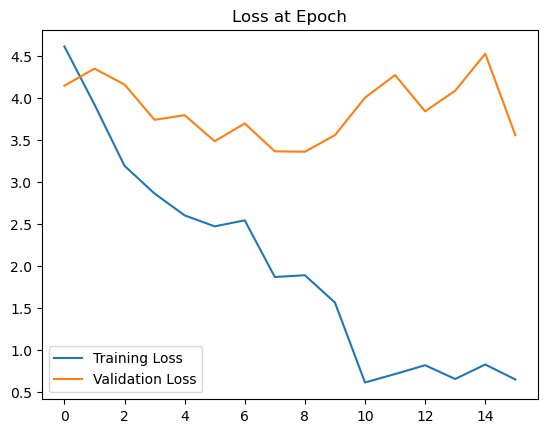

In [31]:
# Convert GPU tensors to CPU tensors, detach them from the computation graph, and then to NumPy arrays
train_losses = [tl.cpu().detach().numpy() for tl in train_losses]
test_losses = [tl.cpu().detach().numpy() for tl in test_losses]

# Now you can plot using matplotlib
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Epoch")
plt.legend()
plt.show(block=True)

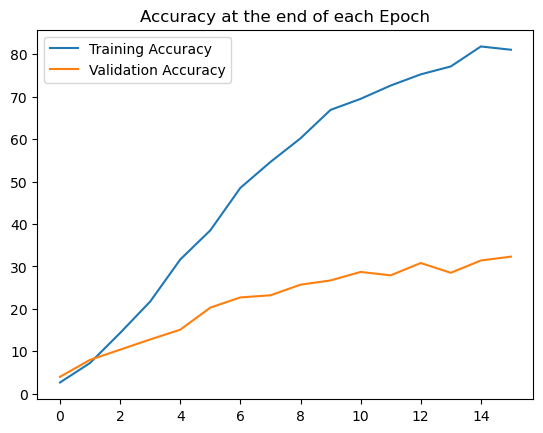

In [35]:
plt.plot([t.cpu()/30 for t in train_correct], label="Training Accuracy")
plt.plot([t.cpu()/10 for t in test_correct], label="Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()

In [36]:
from torch.utils.data import DataLoader

test_load_everything = DataLoader(test_data, batch_size=1024, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for X_test, y_test in test_load_everything:
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum().item()
        total += y_test.size(0)

# Calculate accuracy
accuracy = correct / total
print(f'Accuracy of the model on the test set: {accuracy * 100:.2f}%')

Accuracy of the model on the test set: 31.57%


In [37]:
#torch.save(model.state_dict(), 'model_weights.pth')